In [1]:
from py_experimenter.experimenter import PyExperimenter
import zlib
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import pickle

In [2]:
job_type = "classification"
experimenter = PyExperimenter(
            experiment_configuration_file_path=f"config/experiments-fullforests-{job_type}.cfg",
            use_codecarbon=False
        )

2023-10-03 23:43:48,866  | py-experimenter - INFO     | Initialized and connected to database


In [3]:
df = experimenter.get_table()

In [4]:
df = df[df["scores"].notna()]

In [5]:
df

,ID,openmlid,seed,eps,zfactor,creation_date,status,start_date,name,machine,scores,end_date,error
0,1,3,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 21:57:31,lappy,frank,"[[[""f"", ""f"", ""f"", ""f"", ""f"", ""f"", ""f"", ""f"", ""f""...",2023-10-03 21:57:34,None
1,2,14,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 21:57:34,lappy,frank,"[[[0.06588172, 0.19731169, 0.10382563, 0.27036...",2023-10-03 21:57:46,None
2,3,16,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 21:57:46,lappy,frank,"[[[-10.29700756, -11.66678905, 11.56066895, -2...",2023-10-03 21:58:00,None
3,4,18,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 21:58:00,lappy,frank,"[[[1.0, 0.0, 0.0, 133.1508614, 1.31169276, 162...",2023-10-03 21:58:07,None
4,5,21,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 21:58:08,lappy,frank,"[[[""vhigh"", ""vhigh"", ""2"", ""2"", ""small"", ""low""]...",2023-10-03 21:58:16,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,77,849,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 23:23:03,lappy,frank,"[[[0.843376, 1.128392, -1.684857, 1.017291, 0....",2023-10-03 23:23:07,None
77,78,866,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 23:23:07,lappy,frank,"[[[0.394484, 0.228851, 0.819326, 0.736256, 1.1...",2023-10-03 23:23:14,None
78,79,871,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 23:23:14,lappy,frank,"[[[-2.3482, 3.6314, 5.0289, 10.8721, -1.3852],...",2023-10-03 23:23:18,None
79,80,881,0,0.005,2.0,2023-10-03 21:57:28,done,2023-10-03 23:23:18,lappy,frank,"[[[3.50591, -13.114, ""brown"", -6.55701, 0.0188...",2023-10-03 23:23:31,None


In [6]:
import itertools as it
from tqdm.notebook import tqdm
from scipy import stats

class Analyzer:
    
    def __init__(self,
                 openmlid,
                 prob_history_oob,
                 prob_history_val,
                 Y_train,
                 Y_val,
                 times_fit,
                 times_predict_train,
                 times_predict_val,
                 times_update
                ):
        self.openmlid = openmlid
        self.prob_history_oob = prob_history_oob
        self.prob_history_val = prob_history_val
        self.Y_train = Y_train
        self.Y_val = Y_val
        self.num_trees = prob_history_oob.shape[0]
        if prob_history_oob.shape[0] != prob_history_val.shape[0]:
            raise ValueError("Inconsistent tree count!")
        self.times_fit = times_fit
        self.times_predict_train = times_predict_train
        self.times_predict_val = times_predict_val
        self.times_update = times_update
        
        # compute probabilistic behavior of forest
        self.scores_of_single_trees = {}
        self.single_tree_scores_mean_ests = {}
        self.single_tree_scores_std_ests = {}
        self.scores_of_forests = {}
        self.prob_history_forests = {} # contains for each forest size the probability distribution
        self.correction_terms_for_t1_per_time = {}
        self.num_trees_used_on_avg_for_oob_estimates_at_forest_size = []
        for key, probs_orig, Y in zip(["oob", "val"], [self.prob_history_oob, self.prob_history_val], [self.Y_train, self.Y_val]):
            
            # compute distribution per forest size
            counter = np.zeros((probs_orig.shape[1], probs_orig.shape[2])) # count how many trees voted on each instance (also use classes for convenience)
            probs_forest = np.zeros(counter.shape)
            probs_forest[:] = np.nan
            prob_vars_forest = np.zeros(counter.shape)
            probs_forests = []
            single_tree_scores = []
            single_tree_scores_mean_ests = []
            single_tree_scores_std_ests = []
            forest_scores = []
            correction_terms = []
            
            for t, probs_tree in enumerate(tqdm(probs_orig), start=1):
                mask = ~np.isnan(probs_tree)[:,0]
                mask_insert = mask & np.isnan(probs_forest)[:,0]
                mask_update = mask & ~np.isnan(probs_forest)[:,0]
                old_counter = counter.copy()
                counter[mask] += 1
                probs_forest[mask_insert] = probs_tree[mask_insert]
                probs_forest[mask_update] = (old_counter[mask_update] * probs_forest[mask_update] + probs_tree[mask_update]) / counter[mask_update]
                probs_forests.append(probs_forest.copy())
                
                # compute probability variances
                if t == 1:
                    correction_terms.append(0) # no variance estimate for first tree
                else:
                    prob_vars_forest[mask] = (prob_vars_forest[mask] * old_counter[mask] + (probs_tree[mask] - probs_forests[-2][mask]) * (probs_tree[mask] - probs_forests[-1][mask])) / counter[mask] # this has slight bias
                    correction_term = np.nanmean(prob_vars_forest.sum(axis=1))
                    correction_terms.append(correction_term)
                
                # compute actual scores for this tree and the forest including this tree
                score_tree = np.nanmean(((probs_tree - Y)**2).sum(axis=1))
                score_forest = np.nanmean(((probs_forest - Y)**2).sum(axis=1))
                single_tree_scores.append(score_tree)
                forest_scores.append(score_forest)
                
                # update average number of trees used for an assessment
                if key == "oob":
                    self.num_trees_used_on_avg_for_oob_estimates_at_forest_size.append(int((~np.isnan(probs_orig))[:t,:,0].sum(axis=0).mean()))
                
                # compute empirical mean and std of performance of a single tree per forest size
                #mu = single_tree_scores_mean_ests[-1] if single_tree_scores_mean_ests else 0
                single_tree_scores_mean_ests.append(np.nanmean(single_tree_scores))#((t - 1) * mu + score_tree) / t)
                single_tree_scores_std_ests.append(np.nanstd(single_tree_scores))
            
            # compute probabilities and scores
            self.prob_history_forests[key] = probs_forests
            self.scores_of_single_trees[key] = tuple(single_tree_scores)
            self.single_tree_scores_mean_ests[key] = single_tree_scores_mean_ests
            self.single_tree_scores_std_ests[key] = single_tree_scores_std_ests
            self.scores_of_forests[key] = tuple(forest_scores)
            self.correction_terms_for_t1_per_time[key] = tuple(correction_terms)

        # things to compute lazy
        self.ci_histories = {
            "oob": {},
            "val": {}
        }

    def sample_rf_behavior_from_probs(probs_orig, Y, forest_size=None):
        if forest_size is None:
            forest_size = probs_orig.shape[0]
        permutation = np.random.choice(range(len(probs_orig)), forest_size, replace=False)
        permuted_probs = probs_orig[permutation]

        sums_per_timestep = np.zeros(Y.shape)
        counts_per_timestep = np.zeros(Y.shape)
        mean_distributions_per_forest_size = []
        for t, probs_in_t in enumerate(permuted_probs):
            mask = ~np.isnan(probs_in_t[:,0])
            covered_indices = list(np.where(mask)[0])
            sums_per_timestep[covered_indices] += probs_in_t[covered_indices]
            counts_per_timestep += np.tile(mask, (Y.shape[1], 1)).T
            mean_distributions_per_forest_size.append(sums_per_timestep / counts_per_timestep)
        mean_distributions_per_forest_size = np.array(mean_distributions_per_forest_size)    

        estimated_limit_performance_per_timestep = np.nanmean(((mean_distributions_per_forest_size[:] - Y) ** 2).sum(axis=2), axis=1)
        brier_score_per_forest_size = np.nanmean(((mean_distributions_per_forest_size[:] - Y)**2).sum(axis=2), axis=1)
        return permuted_probs, brier_score_per_forest_size, estimated_limit_performance_per_timestep

    def get_ci_for_expected_performance_at_size_t_based_on_normality(self, forest_size, alpha, sub_forest_size=1, oob=True):
        key = "oob" if oob else "val"
        trees_to_be_considered_for_ci = self.num_trees_used_on_avg_for_oob_estimates_at_forest_size[forest_size-1] if oob else forest_size # this is always t, even for OOB
        est_mean = self.single_tree_scores_mean_ests[key][forest_size - 1]
        est_std = self.single_tree_scores_std_ests[key][forest_size - 1]
        ci = stats.norm.interval(alpha, loc=est_mean, scale=est_std/np.sqrt(trees_to_be_considered_for_ci))
        return ci

    def compute_ci_sequence_for_expected_performance_at_size_t_based_on_normality(self, alpha, sub_forest_size=1, offset=10, oob=True):
        max_forest_size = self.num_trees
        cis = []
        ci_intersection = [-np.inf, np.inf]
        ci_intersection_history = []
        for forest_size in range(offset, max_forest_size + 1):
            ci = self.get_ci_for_expected_performance_at_size_t_based_on_normality(
                forest_size=forest_size,
                alpha=alpha,
                sub_forest_size=sub_forest_size,
                oob=oob
            )
            cis.append(ci)

            ci_intersection[0] = max([ci_intersection[0], ci[0]])
            ci_intersection[1] = min([ci_intersection[1], ci[1]])
            if ci_intersection[0] > ci_intersection[1]:
                #print(f"WARNING: INCONSISTENT CI")
                #raise ValueError("INCONSISTENT")
                pass
            
            ci_intersection_history.append([i for i in ci_intersection])

        ci_intersection_history = np.array(ci_intersection_history)
        first_key = "oob" if oob else "val"
        second_key = alpha
        self.ci_histories[first_key][second_key] = {
            "orig": cis,
            "intersect": ci_intersection_history
        }
    
    def get_num_trees_used_on_avg_for_oob_estimates_at_forest_size(self, forest_size):
        return int((~np.isnan(analyzer.prob_history_oob))[:forest_size,:,0].sum(axis=0).mean())
    
    def get_num_trees_required_for_stable_correction_term_estimate(self, max_iterations_without_new_max = 5, do_discount=True, oob=True):
        new_max_indices = []
        first_plateau_max_index = -1
        cur_max = 0
        cnt_no_new_max = 0
        key = "oob" if oob else "val"
        for t, v in enumerate(self.correction_terms_for_t1_per_time[key], start = 1):
            if do_discount:
                v /= t
            if v < cur_max:
                cnt_no_new_max += 1
            else:
                cur_max = v
                cnt_no_new_max = 0
            
            if cnt_no_new_max >= max_iterations_without_new_max:
                return t
        return np.nan
        

    def get_stopping_point(self, alpha, eps, mode, min_trees=5, use_conservative_correction_term=False, oob=True, use_oob_forest_size_estimate_for_correction_term=False):

        if mode not in ["oracle", "realistic"]:
            raise ValueError("mode must be 'oracle' or 'realistic'")

        key = "oob" if oob else "val"

        tree_scores = self.scores_of_single_trees[key]
        correction_terms = self.correction_terms_for_t1_per_time[key]
        num_tree_count_for_stable_correction_term_estimate = self.get_num_trees_required_for_stable_correction_term_estimate(
            max_iterations_without_new_max=5,
            do_discount=True,
            oob=oob
        )
        
        if mode == "oracle":
            std_of_scores = np.std(tree_scores)
            correction_term = correction_terms[-1]
        for t in range(min_trees, len(tree_scores) + 1):

            # define base of operation if no oracle is used
            if mode != "oracle":
                std_of_scores = np.std(tree_scores[:t])
                correction_term = (self.Y_train.shape[1] / 4) if use_conservative_correction_term else correction_terms[t - 1]

            # compute pessimistic gap to asymptotic performance (uncertainty + noise)
            # for VAL curves, one uses t. For OOB curves, one pretends a smaller forest, of the avg number of trees used for predictions
            trees_to_be_considered_for_ci = self.num_trees_used_on_avg_for_oob_estimates_at_forest_size[t-1] if oob else t # this is always t, even for OOB
            ci = stats.norm.interval(alpha, loc=0, scale=std_of_scores / np.sqrt(trees_to_be_considered_for_ci))
            gap = ci[1] + correction_term / (trees_to_be_considered_for_ci if use_oob_forest_size_estimate_for_correction_term else t)

            # accept t if the gap is small enough
            if t >= num_tree_count_for_stable_correction_term_estimate and gap <= eps:
                return t
        
    def create_ci_plot(self, alpha, eps, oob=True, ax=None):
        first_key = "oob" if oob else "val"
        second_key = alpha
        cis = self.ci_histories[first_key][second_key]["orig"]
        ci_intersections = self.ci_histories[first_key][second_key]["intersect"]
        times = range(1, self.prob_history_oob.shape[0] + 1)

        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = None

        expected_limit_performance = sum(cis[-1]) / 2
        ax.fill_between(times[offset-1:], [e[0] for e in cis], [e[1] for e in cis], alpha=0.2)
        ax.fill_between(times[offset-1:], [e[0] for e in ci_intersections], [e[1] for e in ci_intersections], color="red", alpha=0.2)
        ax.fill_between(times, expected_limit_performance - eps, expected_limit_performance + eps, alpha=0.2)
        ax.set_ylim([expected_limit_performance - 5 * eps, expected_limit_performance + 5 * eps])

        if fig is not None:
            plt.show()

    def create_full_belief_plot(self, alpha, eps, min_trees=5, decision_oob=True, scoring_oob=True, eps_limit_multiplier=3, ax=None):
        first_key_decision = "oob" if decision_oob else "val"
        first_key_scoring = "oob" if scoring_oob else "val"
        second_key = alpha
        cis = np.array([list(e) for e in self.ci_histories[first_key_scoring][second_key]["orig"]])
        #ci_intersections = analyzer.ci_histories[first_key][second_key]["intersect"]

        scores_oob = self.scores_of_forests["oob"]
        scores_val = self.scores_of_forests["val"]
        correction_terms_over_time = self.correction_terms_for_t1_per_time[first_key_scoring]

        times = range(1, len(scores_oob) + 1)

        if ax is None:
            fig, ax = plt.subplots(figsize=(16, 5))
        else:
            fig = None

        # actual performance
        ax.plot(times, scores_oob, label="$Z_t^{oob}$")
        ax.plot(times, scores_val, label="$Z_t^{val}$")

        # expected performance (approximated)
        final_belief_of_correction_term_at_t1 = correction_terms_over_time[-1]
        correction_terms_over_time_based_on_final_belief = final_belief_of_correction_term_at_t1 / times
        expected_limit_performance = sum(cis[-1]) / 2 - final_belief_of_correction_term_at_t1 # take the last estimate (as best estimate), but do NOT divide by t here, because this is inferred via the estimate on t = 1
        ax.axhline(expected_limit_performance, linestyle="--", color="black", linewidth=1, label="$\mathbb{E}[Z_\infty]$")
        ax.plot(times, expected_limit_performance + correction_terms_over_time_based_on_final_belief, color="red", label="$\mathbb{E}[Z_t]$")
        ax.fill_between(times, expected_limit_performance - eps, expected_limit_performance + eps, color="green", alpha=0.2)

        # add confidence intervals around actual observations
        ax.fill_between(
            times[offset-1:],
            [e[0] - final_belief_of_correction_term_at_t1 for e in cis],
            [e[1] - final_belief_of_correction_term_at_t1 for e in cis],
            alpha=0.2
        )

        # plot decision lines
        #decision_line_oracle = self.get_stopping_point(alpha, eps, "oracle", oob=decision_oob)
        decision_line_oob = self.get_stopping_point(alpha, eps, "realistic", min_trees=min_trees, oob=True)
        decision_line_val = self.get_stopping_point(alpha, eps, "oracle", min_trees=min_trees, oob=False)
        ax.axvline(decision_line_oob, color="C0", linestyle="--", linewidth=1, label="$t^{oob}$")
        ax.axvline(decision_line_val, color="C1", linestyle="--", linewidth=1, label="$t^{val}$")

        ax.set_ylim([expected_limit_performance - eps_limit_multiplier * eps, expected_limit_performance + eps_limit_multiplier * eps])

        ax.legend()
        ax.set_title(f"Stopping after {decision_line_oob} trees (OOB). Perfect decision would be {decision_line_val} (VAL orcale)")

        if fig is not None:
            plt.show()
            
    def plot_gap_over_time(self, alpha, eps, oob, min_trees=2, ax = None):
        if ax is None:
            fig, axs = plt.subplots(3, 1, figsize=(16, 12))
        else:
            fig = None

        
        key = "oob" if oob else "val"

        times = np.arange(1, self.num_trees + 1)
        correction_terms_over_time_real = self.correction_terms_for_t1_per_time[key] / times
        correction_terms_over_time_omniscient = self.correction_terms_for_t1_per_time[key][-1] / times
        correction_terms_over_time_pessimistic = (self.Y_train.shape[1] / (4 * times))
        confidence_band_sizes = np.array([(e[1] - e[0]) / 2 for e in self.ci_histories[key][alpha]["orig"]])

        #print(correction_terms_over_time_real[:10])
        #print(correction_terms_over_time_omniscient[:10])

        offset = len(times) - len(confidence_band_sizes)
        gaps_real = confidence_band_sizes + correction_terms_over_time_real[offset:]
        gaps_known_variance = confidence_band_sizes + correction_terms_over_time_omniscient[offset:]
        gaps_pessimistic_estimate = confidence_band_sizes + correction_terms_over_time_pessimistic[offset:]

        # real plot
        max_xlim = 0
        max_gap = np.max([np.max(gaps_real), np.max(gaps_known_variance)])
        for ax, gaps in zip(axs, [gaps_real, gaps_known_variance, gaps_pessimistic_estimate]):
            ax.fill_between(times[offset:], 0, confidence_band_sizes, alpha=0.2, label="uncertainty about $\mu$")
            ax.fill_between(times[offset:], confidence_band_sizes, gaps, alpha=0.2, label="variance deviation")
            ax.plot(times[offset:], gaps, color="red", alpha=0.5, label="Total Gap to $\\mu$.")
            ax.axhline(0, linestyle="-", color="black", linewidth=1)
            ax.fill_between(times, 0, eps, alpha=0.2, color="green", label=f"acceptance area for $\\varepsilon = {eps}$")

            accepting_indices = np.where(gaps < eps)[0]
            
            num_trees_required_for_stable_correction_term_estimate = self.get_num_trees_required_for_stable_correction_term_estimate()
            ax.fill_between([1, num_trees_required_for_stable_correction_term_estimate], [0, 0], [1, 1], color="red", alpha=0.2)
            
            if len(accepting_indices) > 0:
                stopping_point = np.max([min_trees, offset + accepting_indices[0], num_trees_required_for_stable_correction_term_estimate])
                ax.axvline(stopping_point, color="black", linestyle="--", label="Oracle Stopping Point")
            else:
                stopping_point = np.nan

            if not np.isnan(stopping_point):
                max_xlim = np.max([max_xlim, min([2 * stopping_point, len(gaps_real)])])

            ax.set_title(f"Stopping point: {stopping_point} trees")
            #ax.set_xscale("log")
        #ax.plot(range(1, self.num_trees + 1), self.correction_terms_for_t1_per_time_val, label="$\mathbb{V}_{val}$")

            ax.legend()
            ax.set_ylim([0, 2 * eps])

        for ax in axs:
            ax.set_xlim([offset, max_xlim])

        if fig is not None:
            plt.show()
            
    def plot_estimates_of_correction_term(self, ax = None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(20, 4))
        else:
            fig = None

        ax.plot(range(1, self.num_trees + 1), self.correction_terms_for_t1_per_time["oob"], label="$\mathbb{V}_{oob}$")
        ax.plot(range(1, self.num_trees + 1), self.correction_terms_for_t1_per_time["val"], label="$\mathbb{V}_{val}$")
        
        x_limit = 150
        for (key, oob), do_discount in it.product(zip(["oob", "val"], [True, False]), [True, False]):
            color = f"C{0 if oob else 1}"
            linestyle="--" if do_discount else "dotted"
            num_tree_count_for_stable_correction_term_estimate = self.get_num_trees_required_for_stable_correction_term_estimate(oob=oob, do_discount=do_discount)
            ax.axvline(num_tree_count_for_stable_correction_term_estimate, linestyle=linestyle, color=color, label="num trees for stable estimate of $\mathbb{V}_{" + key + "}$ " + ("" if do_discount else "not") + " discounting")
            x_limit = max([x_limit, num_tree_count_for_stable_correction_term_estimate + 10])
        
        ax.set_xlim([1, x_limit])
        ax.set_xscale("log")

        if fig is not None:
            ax.legend()
            ax.set_title("Estimates of correction term $\\varphi(1)$ over time.")
            plt.show()

In [7]:
import os

def get_analyzer_for_row(row):
    results = json.loads(row["scores"])
    
    Y_train = np.array(results[1])
    Y_test = np.array(results[2])
    prob_history_oob = np.array(json.loads(zlib.decompress(eval(results[3])).decode().replace("nan", "-1")))
    prob_history_val = np.array(json.loads(zlib.decompress(eval(results[4])).decode().replace("nan", "-1")))
    
    num_classes = Y_train.shape[1]
    
    prob_history_oob[prob_history_oob < 0] = np.nan
    prob_history_val[prob_history_val < 0] = np.nan
    
    # times
    times_fit = results[-4]
    times_predict_train = results[-3]
    times_predict_val = results[-2]
    times_update = results[-1]
    
    analyzer = Analyzer(int(openmlid), prob_history_oob, prob_history_val, Y_train, Y_test, times_fit, times_predict_train, times_predict_val, times_update)
    return analyzer

def write_analyzer_to_disk(openmlid, seed):
    row = df[(df["openmlid"] == str(openmlid)) & (df["seed"] == seed)].iloc[0]
    analyzer = get_analyzer_for_row(row)
    with open(f"analyzers/{openmlid}_{seed}.ana", "wb") as f:
        pickle.dump(analyzer, f)

def get_analyzer_from_disk(openmlid, seed):
    with open(f"analyzers/{openmlid}_{seed}.ana", "rb") as f:
        return pickle.load(f)
    
def is_analyzer_serialized(openmlid, seed):
    return os.path.exists(f"analyzers/{openmlid}_{seed}.ana")

In [14]:
for openmlid in tqdm(pd.unique(df["openmlid"])):
    seed = 0
    if int(openmlid) <= 1000 and not is_analyzer_serialized(openmlid, seed):
        print(openmlid)
        write_analyzer_to_disk(openmlid, 0)

  0%|          | 0/76 [00:00<?, ?it/s]

3


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

14


  0%|          | 0/1380 [00:00<?, ?it/s]

  0%|          | 0/1380 [00:00<?, ?it/s]

16


  0%|          | 0/1552 [00:00<?, ?it/s]

  0%|          | 0/1552 [00:00<?, ?it/s]

18


  0%|          | 0/921 [00:00<?, ?it/s]

  0%|          | 0/921 [00:00<?, ?it/s]

21


  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

22


  0%|          | 0/1137 [00:00<?, ?it/s]

  0%|          | 0/1137 [00:00<?, ?it/s]

23


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/628 [00:00<?, ?it/s]

24


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

26


  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

28


  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

30


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

31


  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

32


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

33


  0%|          | 0/1396 [00:00<?, ?it/s]

  0%|          | 0/1396 [00:00<?, ?it/s]

36


  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

38


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

44


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

46


  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

54


  0%|          | 0/984 [00:00<?, ?it/s]

  0%|          | 0/984 [00:00<?, ?it/s]

57


  0%|          | 0/559 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]

60


  0%|          | 0/392 [00:00<?, ?it/s]

  0%|          | 0/392 [00:00<?, ?it/s]

61


  0%|          | 0/1396 [00:00<?, ?it/s]

  0%|          | 0/1396 [00:00<?, ?it/s]

179


  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

181


  0%|          | 0/1304 [00:00<?, ?it/s]

  0%|          | 0/1304 [00:00<?, ?it/s]

182


  0%|          | 0/452 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

185


  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

188


  0%|          | 0/1572 [00:00<?, ?it/s]

  0%|          | 0/1572 [00:00<?, ?it/s]

351


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

357


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

389


  0%|          | 0/2040 [00:00<?, ?it/s]

  0%|          | 0/2040 [00:00<?, ?it/s]

391


  0%|          | 0/1639 [00:00<?, ?it/s]

  0%|          | 0/1639 [00:00<?, ?it/s]

392


  0%|          | 0/2522 [00:00<?, ?it/s]

  0%|          | 0/2522 [00:00<?, ?it/s]

395


  0%|          | 0/3273 [00:00<?, ?it/s]

  0%|          | 0/3273 [00:00<?, ?it/s]

396


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/906 [00:00<?, ?it/s]

398


  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/2180 [00:00<?, ?it/s]

401


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 0/2655 [00:00<?, ?it/s]

679


  0%|          | 0/649 [00:00<?, ?it/s]

  0%|          | 0/649 [00:00<?, ?it/s]

715


  0%|          | 0/1909 [00:00<?, ?it/s]

  0%|          | 0/1909 [00:00<?, ?it/s]

718


  0%|          | 0/2545 [00:00<?, ?it/s]

  0%|          | 0/2545 [00:00<?, ?it/s]

720


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

722


  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

723


  0%|          | 0/1801 [00:00<?, ?it/s]

  0%|          | 0/1801 [00:00<?, ?it/s]

727


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

728


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

734


  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

735


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

737


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

740


  0%|          | 0/849 [00:00<?, ?it/s]

  0%|          | 0/849 [00:00<?, ?it/s]

741


  0%|          | 0/376 [00:00<?, ?it/s]

  0%|          | 0/376 [00:00<?, ?it/s]

743


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

751


  0%|          | 0/853 [00:00<?, ?it/s]

  0%|          | 0/853 [00:00<?, ?it/s]

752


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/2580 [00:00<?, ?it/s]

761


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

772


  0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/549 [00:00<?, ?it/s]

797


  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/2475 [00:00<?, ?it/s]

799


  0%|          | 0/522 [00:00<?, ?it/s]

  0%|          | 0/522 [00:00<?, ?it/s]

803


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

806


  0%|          | 0/2017 [00:00<?, ?it/s]

  0%|          | 0/2017 [00:00<?, ?it/s]

807


  0%|          | 0/303 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

813


  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

816


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

819


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

821


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

822


  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]

823


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

833


  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

837


  0%|          | 0/2188 [00:00<?, ?it/s]

  0%|          | 0/2188 [00:00<?, ?it/s]

843


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

845


  0%|          | 0/1018 [00:00<?, ?it/s]

  0%|          | 0/1018 [00:00<?, ?it/s]

846


  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

847


  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

849


  0%|          | 0/1360 [00:00<?, ?it/s]

  0%|          | 0/1360 [00:00<?, ?it/s]

866


  0%|          | 0/1963 [00:00<?, ?it/s]

  0%|          | 0/1963 [00:00<?, ?it/s]

871


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

881


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

897


  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

In [9]:
def create_full_belief_plot(self, alpha, eps, min_trees=5, decision_oob=True, scoring_oob=True, eps_limit_multiplier=3, ax=None):
    first_key_decision = "oob" if decision_oob else "val"
    first_key_scoring = "oob" if scoring_oob else "val"
    second_key = alpha

    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 5))
    else:
        fig = None
    
    decision_lines = {}
    x_lim = 400
    for i, key in enumerate(["oob", "val"]):
        color = f"C{i}"
        scores = self.scores_of_forests[key]
        correction_terms_over_time = self.correction_terms_for_t1_per_time[key]
        cis = np.array([list(e) for e in self.ci_histories[key][second_key]["orig"]])

        times = range(1, len(scores) + 1)

        # actual performance
        ax.plot(times, scores, color=color, label="$Z_t^{" + key + "}$")

        # expected performance (approximated)
        final_belief_of_correction_term_at_t1 = correction_terms_over_time[-1]
        correction_terms_over_time_based_on_final_belief = final_belief_of_correction_term_at_t1 / times
        expected_limit_performance = sum(cis[-1]) / 2 - final_belief_of_correction_term_at_t1 # take the last estimate (as best estimate), but do NOT divide by t here, because this is inferred via the estimate on t = 1
        ax.axhline(expected_limit_performance, linestyle="--", color=color, linewidth=1, label="$\mathbb{E}[Z_\infty]$")
        ax.plot(times, expected_limit_performance + correction_terms_over_time_based_on_final_belief, color=color, linestyle="dotted", label="$\mathbb{E}[Z_t]$")
        if key == "val":
            ax.fill_between(times, expected_limit_performance - eps, expected_limit_performance + eps, color="green", alpha=0.2)

        # add confidence intervals for what is believed to be the true final performance
        ax.fill_between(
            times[offset-1:],
            [e[0] - final_belief_of_correction_term_at_t1 for e in cis],
            [e[1] - final_belief_of_correction_term_at_t1 for e in cis],
            alpha=0.2
        )

        # plot decision lines
        oob = key=="oob"
        decision_line = self.get_stopping_point(alpha, eps, "realistic" if oob else "oracle", min_trees=min_trees, oob=oob)
        decision_lines[key] = decision_line
        ax.axvline(decision_line, color=color, linestyle="--", linewidth=1, label="$t^{" + key + "}$")
        if oob:
            decision_line = self.get_stopping_point(alpha, eps, "realistic" if oob else "oracle", min_trees=min_trees, oob=oob, use_oob_forest_size_estimate_for_correction_term=True)
            decision_lines[key + "_conservative"] = decision_line
            ax.axvline(decision_line, color=color, linestyle="dotted", linewidth=1, label="$t^{" + key + "}$ OOB pure")
            x_lim = np.max([x_lim, decision_line * 1.2])

    ax.set_xlim([1, x_lim])
    ax.set_xscale("log")
    ax.set_ylim([expected_limit_performance - eps_limit_multiplier * eps, expected_limit_performance + eps_limit_multiplier * eps])

    ax.legend()
    ax.set_title(f"Stopping after {decision_lines['oob']} trees (OOB). Perfect decision would be {decision_lines['val']} (VAL orcale)")

    if fig is not None:
        plt.show()
        
def plot_estimates_of_correction_term(self, axs = None):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))
    else:
        fig = None

    times = np.arange(1, self.num_trees + 1)
        
    # correction term without t
    ax = axs[0]
    ax.plot(times, self.correction_terms_for_t1_per_time["oob"], label="$\mathbb{V}_{oob}$")
    ax.plot(times, self.correction_terms_for_t1_per_time["val"], label="$\mathbb{V}_{val}$")
    x_limit = 150
    for (key, oob), do_discount in it.product(zip(["oob", "val"], [True, False]), [True, False]):
        color = f"C{0 if oob else 1}"
        linestyle="--" if do_discount else "dotted"
        num_tree_count_for_stable_correction_term_estimate = self.get_num_trees_required_for_stable_correction_term_estimate(oob=oob, do_discount=do_discount)
        ax.axvline(num_tree_count_for_stable_correction_term_estimate, linestyle=linestyle, color=color, label="num trees for stable estimate of $\mathbb{V}_{" + key + "}$ " + ("" if do_discount else "not") + " discounting")
        x_limit = max([x_limit, num_tree_count_for_stable_correction_term_estimate + 10])

    ax.set_xlim([1, x_limit])
    ax.set_xscale("log")
    
    # correction term with t
    ax = axs[1]
    ax.plot(times, self.correction_terms_for_t1_per_time["oob"] / times, label="$\mathbb{V}_{oob}$")
    ax.plot(times, self.correction_terms_for_t1_per_time["val"] / times, label="$\mathbb{V}_{val}$")
    x_limit = 150
    for (key, oob), do_discount in it.product(zip(["oob", "val"], [True, False]), [True, False]):
        color = f"C{0 if oob else 1}"
        linestyle="--" if do_discount else "dotted"
        num_tree_count_for_stable_correction_term_estimate = self.get_num_trees_required_for_stable_correction_term_estimate(oob=oob, do_discount=do_discount)
        ax.axvline(num_tree_count_for_stable_correction_term_estimate, linestyle=linestyle, color=color, label="num trees for stable estimate of $\mathbb{V}_{" + key + "}$ " + ("" if do_discount else "not") + " discounting")
        x_limit = max([x_limit, num_tree_count_for_stable_correction_term_estimate + 10])

    ax.set_xlim([1, x_limit])
    ax.set_xscale("log")

    if fig is not None:
        ax.legend()
        ax.set_title("Estimates of correction term $\\varphi(1)$ over time.")
        plt.show()
        
def plot_gap_over_time(self, alpha, eps, oob, min_trees=2, ax = None):
    if ax is None:
        fig, axs = plt.subplots(2, 1, figsize=(16, 8))
    else:
        fig = None


    key = "oob" if oob else "val"

    times = np.arange(1, self.num_trees + 1) # here we need to use times for both OOB and validation curves
    num_trees_for_estimates_oob = np.array(self.num_trees_used_on_avg_for_oob_estimates_at_forest_size)
    correction_terms_over_time_real_oob = self.correction_terms_for_t1_per_time[key] / num_trees_for_estimates_oob
    correction_terms_over_time_real_estimated_for_val = self.correction_terms_for_t1_per_time[key] / times
    #correction_terms_over_time_omniscient = self.correction_terms_for_t1_per_time[key][-1] / num_trees_for_estimates
    #correction_terms_over_time_pessimistic = (self.Y_train.shape[1] / (4 * num_trees_for_estimates))
    confidence_band_sizes = np.array([(e[1] - e[0]) / 2 for e in self.ci_histories[key][alpha]["orig"]])

    #print(correction_terms_over_time_real[:10])
    #print(correction_terms_over_time_omniscient[:10])

    offset = len(times) - len(confidence_band_sizes)
    gaps_real = confidence_band_sizes + correction_terms_over_time_real_oob[offset:]
    gaps_anticipated_for_val = confidence_band_sizes + correction_terms_over_time_real_estimated_for_val[offset:]
    #gaps_known_variance = confidence_band_sizes + correction_terms_over_time_omniscient[offset:]
    #gaps_pessimistic_estimate = confidence_band_sizes + correction_terms_over_time_pessimistic[offset:]

    # real plot
    max_xlim = 0
    max_gap = np.max([np.max(gaps_real), np.max(gaps_anticipated_for_val)])
    for ax, gaps in zip(axs, [gaps_real, gaps_anticipated_for_val]):
        ax.fill_between(times[offset:], 0, confidence_band_sizes, color=f"C{0 if oob else 1}", alpha=0.2, label="uncertainty about $\mu$")
        ax.fill_between(times[offset:], confidence_band_sizes, gaps, color="purple", alpha=0.2, label="variance deviation")
        ax.plot(times[offset:], gaps, color="red", alpha=0.5, label="Total Gap to $\\mu$.")
        ax.axhline(0, linestyle="-", color="black", linewidth=1)
        ax.fill_between(times, 0, eps, alpha=0.2, color="green", label=f"acceptance area for $\\varepsilon = {eps}$")

        accepting_indices = [t + 1 for t in np.where(gaps < eps)[0] if t >= min_trees]
        
        num_trees_required_for_stable_correction_term_estimate = self.get_num_trees_required_for_stable_correction_term_estimate()
        ax.fill_between([1, num_trees_required_for_stable_correction_term_estimate], [0, 0], [1, 1], color="red", alpha=0.2)

        if len(accepting_indices) > 0:
            stopping_point = np.max([min_trees, offset + accepting_indices[0], num_trees_required_for_stable_correction_term_estimate])
            ax.axvline(stopping_point, color="black", linestyle="--", label="Oracle Stopping Point")
        else:
            stopping_point = np.nan

        if not np.isnan(stopping_point):
            max_xlim = np.max([max_xlim, min([2 * stopping_point, len(gaps_real)])])

        ax.set_title(f"Stopping point: {stopping_point} trees")
        #ax.set_xscale("log")
    #ax.plot(range(1, self.num_trees + 1), self.correction_terms_for_t1_per_time_val, label="$\mathbb{V}_{val}$")

        ax.legend()
        ax.set_ylim([0, 2 * eps])

    for ax in axs:
        ax.set_xlim([offset, max_xlim])

    if fig is not None:
        plt.show()

eps_base = 0.01
for openmlid in pd.unique(df["openmlid"]):
    seed = 0
    if not is_analyzer_serialized(openmlid, seed):
        continue
    print(openmlid)
    analyzer = get_analyzer_from_disk(openmlid, seed)
    times = np.arange(1, 21)
    alpha_eps_combos = list(zip([0.5, 0.6, 0.8, 0.95], [0.8 * eps_base, 0.9 * eps_base, eps_base, 2 * eps_base]))
    offset=2
    alpha = 0.5
    alphas = [alpha]
    for oob in [False, True]:
        for alpha in alphas:
            analyzer.compute_ci_sequence_for_expected_performance_at_size_t_based_on_normality(
                alpha=alpha,
                offset=offset,
                oob=oob
            )
    
    #stopping_points_for_profiles = []
    #for alpha, eps in alpha_eps_combos:
        #stopping_points_for_profiles.append(analyzer.get_stopping_point(alpha=alpha, eps=eps, mode="realistic", min_trees=5, oob=True))
    singular_stopping_point = analyzer.get_stopping_point(alpha=alpha, eps=eps_base, mode="realistic", min_trees=5, oob=True, use_oob_forest_size_estimate_for_correction_term=False)
    #actual_stopping_point = max(stopping_points_for_profiles)
    actual_stopping_point = singular_stopping_point
    if actual_stopping_point is not None and not np.isnan(actual_stopping_point):
        #print(stopping_points_for_profiles, actual_stopping_point, f"Saving compare to singular stopping point: {singular_stopping_point - actual_stopping_point}.")
        val_curve = analyzer.scores_of_forests["val"]
        oob_curve = analyzer.scores_of_forests["oob"]
        val_gap = np.abs(val_curve[actual_stopping_point] - np.mean(val_curve[-10:]))
        oob_gap = np.abs(oob_curve[actual_stopping_point] - np.mean(oob_curve[-10:]))
        print(actual_stopping_point, f"Saving compared to sklearn: {100 - actual_stopping_point}", np.round(oob_gap, 4), np.round(val_gap, 4), max([val_gap, oob_gap]) < eps_base)
        if val_gap > eps_base:
            create_full_belief_plot(analyzer, alpha=alpha, eps=eps_base, decision_oob=True, scoring_oob=False, eps_limit_multiplier=5)
            plt.show()
            plot_estimates_of_correction_term(analyzer)
            plt.show()

            plot_gap_over_time(analyzer,
                alpha=alpha, # deliberately use some higher alpha here.
                oob=True,
                eps = eps_base,
                min_trees=5
            )
            plt.show()

3
24 Saving compared to sklearn: 76 0.008 0.0012 True


/tmp/ipykernel_23214/3681261353.py:126: RuntimeWarning: divide by zero encountered in scalar divide
  ci = stats.norm.interval(alpha, loc=est_mean, scale=est_std/np.sqrt(trees_to_be_considered_for_ci))


14
112 Saving compared to sklearn: -12 0.0095 0.0075 True
16
147 Saving compared to sklearn: -47 0.0095 0.0026 True
18
57 Saving compared to sklearn: 43 0.0173 0.0032 False
21
101 Saving compared to sklearn: -1 0.0077 0.0047 True
22
95 Saving compared to sklearn: 5 0.0081 0.0048 True
23
101 Saving compared to sklearn: -1 0.0089 0.0086 True
24
13 Saving compared to sklearn: 87 0.0006 0.0 True
26


/home/felix/anaconda3/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/felix/anaconda3/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


55 Saving compared to sklearn: 45 0.0083 0.0026 True
28


KeyboardInterrupt: 

In [15]:
eps_base = 0.01
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
datasets = [i for i in pd.unique(df["openmlid"]) if is_analyzer_serialized(i, 0)]
rows = []

pbar = tqdm(total=len(alphas) * len(datasets))
for openmlid in datasets:
    
    # initialize analyzer
    seed = 0
    print(openmlid)
    analyzer = get_analyzer_from_disk(openmlid, seed)
    times = np.arange(1, 21)
    offset=2
    
    # check regrets for different alphas
    row = [openmlid]
    for alpha in alphas:
        for oob in [False, True]:
            analyzer.compute_ci_sequence_for_expected_performance_at_size_t_based_on_normality(
                alpha=alpha,
                offset=offset,
                oob=oob
            )

        stopping_point = analyzer.get_stopping_point(alpha=alpha, eps=eps_base, mode="realistic", min_trees=5, oob=True, use_oob_forest_size_estimate_for_correction_term=False)
        if stopping_point is not None and not np.isnan(stopping_point):
            val_curve = analyzer.scores_of_forests["val"]
            oob_curve = analyzer.scores_of_forests["oob"]
            val_gap = np.abs(val_curve[stopping_point] - np.mean(val_curve[-10:]))
            oob_gap = np.abs(oob_curve[stopping_point] - np.mean(oob_curve[-10:]))
            times_fit = np.array(analyzer.times_fit)
            times_overhead = np.array(analyzer.times_predict_train) + np.array(analyzer.times_update)
            
            time_100 = times_fit[:100].sum()
            time_we = (times_fit[:stopping_point] + times_overhead[:stopping_point]).sum()
            row.extend([stopping_point, oob_gap, val_gap, val_gap <= eps_base, time_100, time_we])
        pbar.update(1)
    rows.append(row)
pbar.close()

  0%|          | 0/836 [00:00<?, ?it/s]

3


/tmp/ipykernel_23214/3681261353.py:126: RuntimeWarning: divide by zero encountered in scalar divide
  ci = stats.norm.interval(alpha, loc=est_mean, scale=est_std/np.sqrt(trees_to_be_considered_for_ci))


14
16
18
21
22
23
24
26
28
30
31
32
33
36
38
44
46
54
57
60
61
179
181
182
185
188
351
357
389
391
392
395
396
398
401
679
715
718
720
722
723
727
728
734
735
737
740


IndexError: tuple index out of range

In [19]:
cols = ["openmlid"]
for alpha in alphas:
    cols.extend([f"t_{alpha}", f"oob_val_{alpha}", f"gap_val_{alpha}", f"ok_{alpha}", f"time_100_{alpha}", f"time_asrf_{alpha}"])
df_results = pd.DataFrame(rows, columns=cols).dropna()
df_results

,openmlid,t_0.1,oob_val_0.1,gap_val_0.1,ok_0.1,time_100_0.1,time_asrf_0.1,t_0.2,oob_val_0.2,gap_val_0.2,...,gap_val_0.95,ok_0.95,time_100_0.95,time_asrf_0.95,t_0.99,oob_val_0.99,gap_val_0.99,ok_0.99,time_100_0.99,time_asrf_0.99
0,3,10,0.026564,0.003181,True,1.075290,0.113410,10,0.026564,0.003181,...,0.000355,True,1.075290,1.261446,245.0,0.000161,0.000064,True,1.075290,1.429247
1,14,54,0.022319,0.010370,False,0.354864,0.218839,64,0.019133,0.007310,...,0.000908,True,0.354864,1.276616,695.0,0.000256,0.000311,True,0.354864,1.919868
2,16,60,0.024309,0.011886,False,0.350425,0.241864,75,0.018876,0.007318,...,0.000048,True,0.350425,1.581892,924.0,0.000227,0.000320,True,0.350425,2.366345
3,18,32,0.029082,0.007564,True,0.228633,0.091084,37,0.023784,0.005812,...,0.001524,True,0.228633,0.405789,253.0,0.003043,0.000949,True,0.228633,0.543736
4,21,32,0.023299,0.010071,False,0.123453,0.052381,42,0.020930,0.007458,...,0.000141,True,0.123453,0.547752,726.0,0.001194,0.000169,True,0.123453,0.853677
5,22,50,0.019875,0.008199,True,0.311194,0.180822,59,0.017263,0.007455,...,0.003775,True,0.311194,0.873987,538.0,0.001893,0.002219,True,0.311194,1.341830
6,23,53,0.018700,0.016328,False,0.140440,0.095713,63,0.016125,0.011945,...,0.001907,True,0.140440,0.472220,519.0,0.001007,0.000690,True,0.140440,0.702407
7,24,13,0.000556,0.000029,True,0.360464,0.090813,13,0.000556,0.000029,...,0.000029,True,0.360464,0.090813,13.0,0.000556,0.000029,True,0.360464,0.090813
8,26,20,0.023537,0.008507,True,0.460104,0.311151,28,0.018757,0.005430,...,0.000524,True,0.460104,1.064097,357.0,0.000303,0.000522,True,0.460104,1.496482
9,28,27,0.023334,0.010761,False,0.547024,0.211848,32,0.021296,0.009240,...,0.003671,True,0.547024,0.783791,191.0,0.003267,0.002160,True,0.547024,1.042683


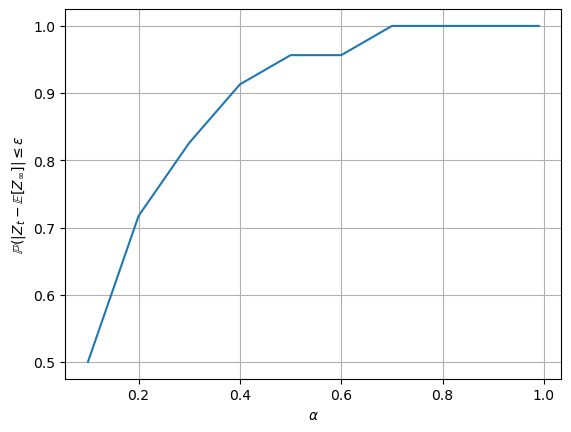

In [29]:
ok_proportion_by_alphas = [df_results[f"ok_{alpha}"].astype(int).mean() for alpha in alphas]
fig, ax = plt.subplots()
ax.plot(alphas, ok_proportion_by_alphas)
ax.grid()
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\mathbb{P}(|Z_t - \\mathbb{E}[Z_\\infty]| \leq \\varepsilon$")
plt.show()

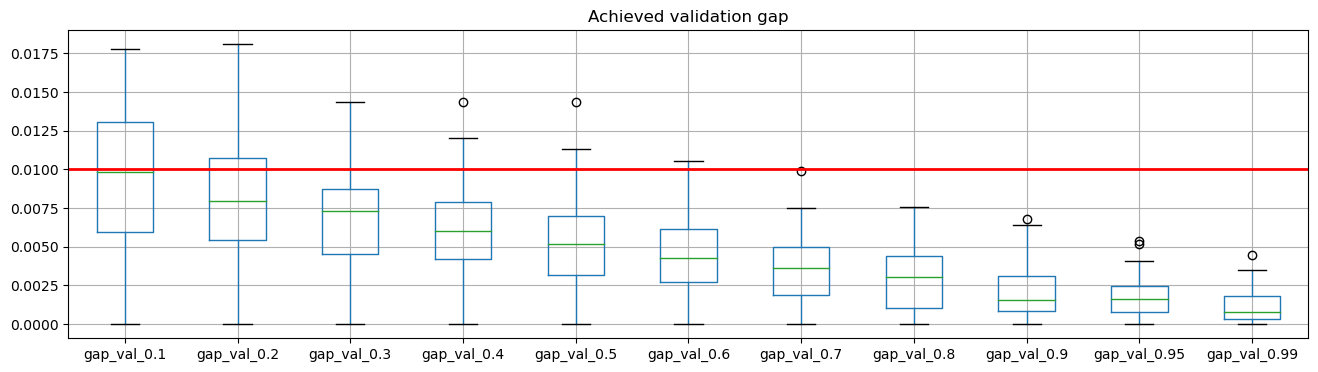

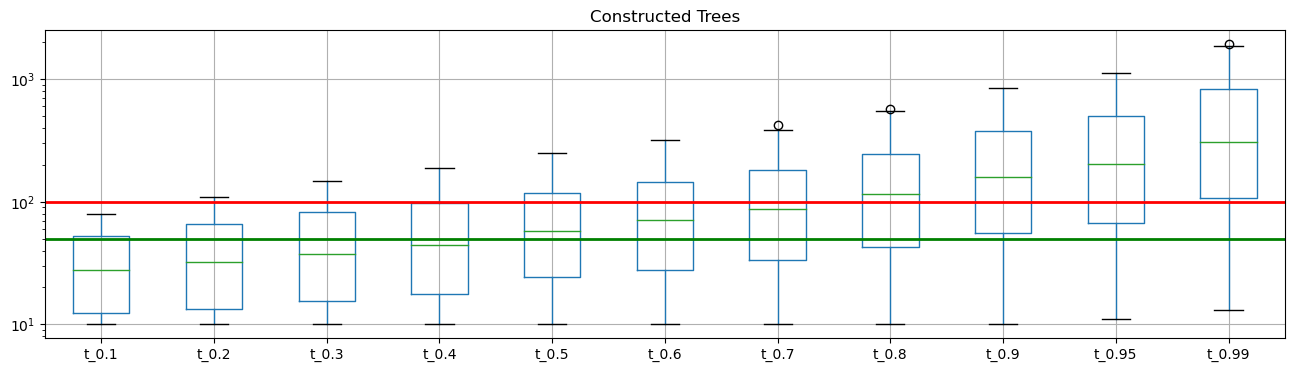

In [30]:
fig, ax = plt.subplots(figsize=(16, 4))
df_results[[c for c in df_results.columns if "gap_val" in c]].boxplot(ax=ax)
ax.axhline(eps_base, linestyle="-", color="red", linewidth=2)
ax.set_title("Achieved validation gap")
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
df_results[[c for c in df_results.columns if "t_" in c]].boxplot(ax=ax)
ax.axhline(100, linestyle="-", color="red", linewidth=2)
ax.axhline(50, linestyle="-", color="green", linewidth=2)
ax.set_yscale("log")
ax.set_title("Constructed Trees")
plt.show()

/tmp/ipykernel_23214/3742570544.py:18: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(-1, color="blue", linestyle="--")
/tmp/ipykernel_23214/3742570544.py:19: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(0, color="green", linestyle="--")
/tmp/ipykernel_23214/3742570544.py:20: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(1, color="orange", linestyle="--")


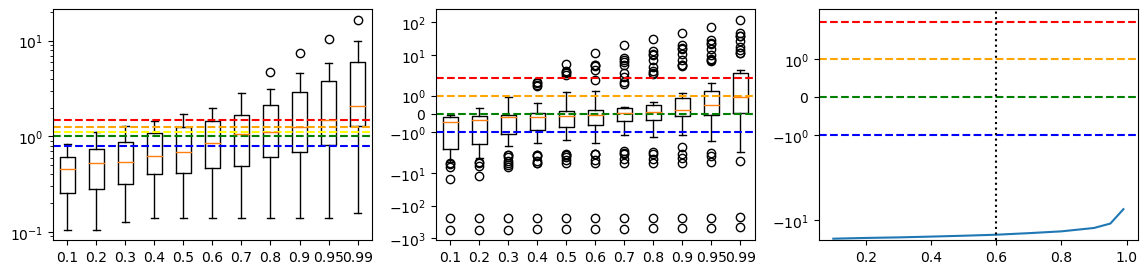

In [31]:
runtimes_asrf = df_results[[c for c in df_results.columns if "time_asrf" in c]].values
runtimes_baseline = df_results["time_100_0.1"].values
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
ax = axs[0]
ax.boxplot([row / runtimes_baseline for row in runtimes_asrf.T])
ax.set_xticklabels(alphas)
ax.axhline(0.8, color="blue", linestyle="--")
ax.axhline(1, color="green", linestyle="--")
ax.axhline(1.1, color="yellow", linestyle="--")
ax.axhline(1.25, color="orange", linestyle="--")
ax.axhline(1.5, color="red", linestyle="--")
ax.set_yscale("log")

ax = axs[1]
ax.boxplot([row - runtimes_baseline for row in runtimes_asrf.T])
ax.set_xticklabels(alphas)
ax.set_yscale("symlog")
ax.axhline(-1, color="blue", linestyle="--")
ax.axhline(0, color="green", linestyle="--")
ax.axhline(1, color="orange", linestyle="--")
ax.axhline(2, color="red", linestyle="--")

ax = axs[2]
ax.plot(alphas, np.array([row - runtimes_baseline for row in runtimes_asrf.T]).mean(axis=1))
ax.axhline(-1, color="blue", linestyle="--")
ax.axhline(0, color="green", linestyle="--")
ax.axhline(1, color="orange", linestyle="--")
ax.axhline(2, color="red", linestyle="--")
ax.axvline(0.6, linestyle="dotted", color="black")
ax.set_yscale("symlog")
plt.show()

In [33]:

idx = 5

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5126f987c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5126f98460>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5126f995a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5126f99cf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5126f99f60>],
 'means': []}

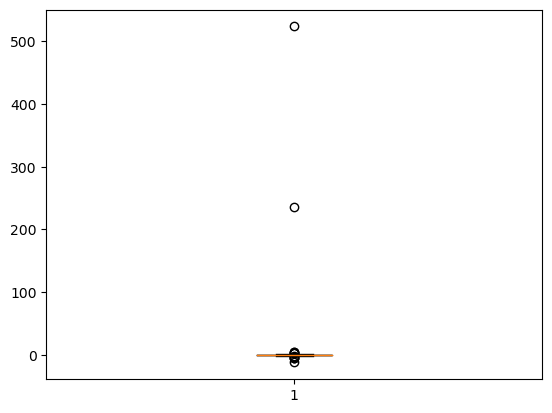

0.1


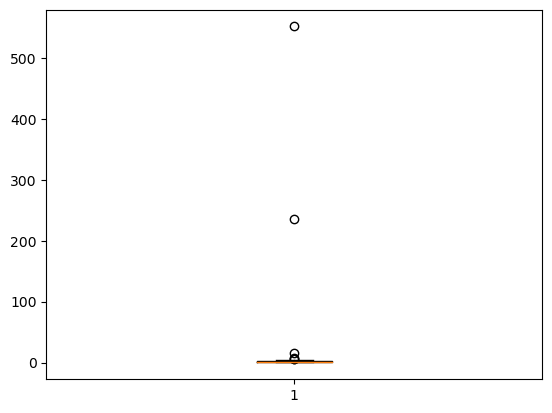

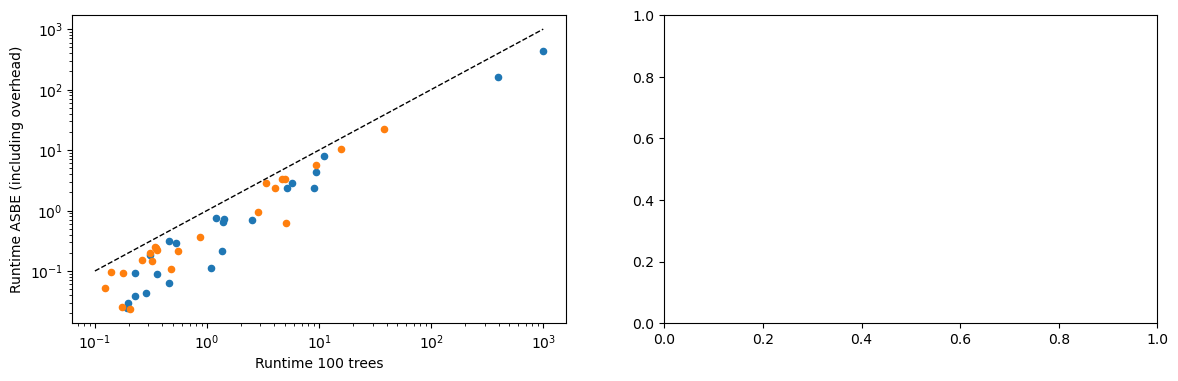

0.2


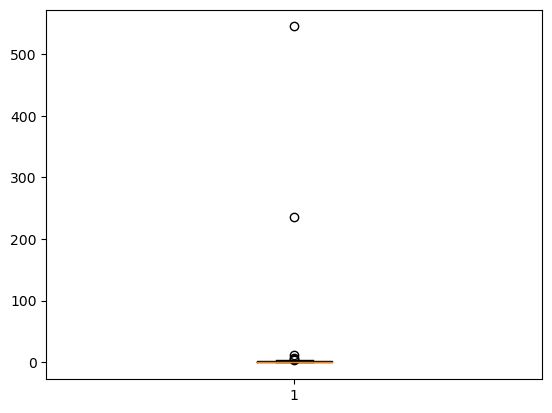

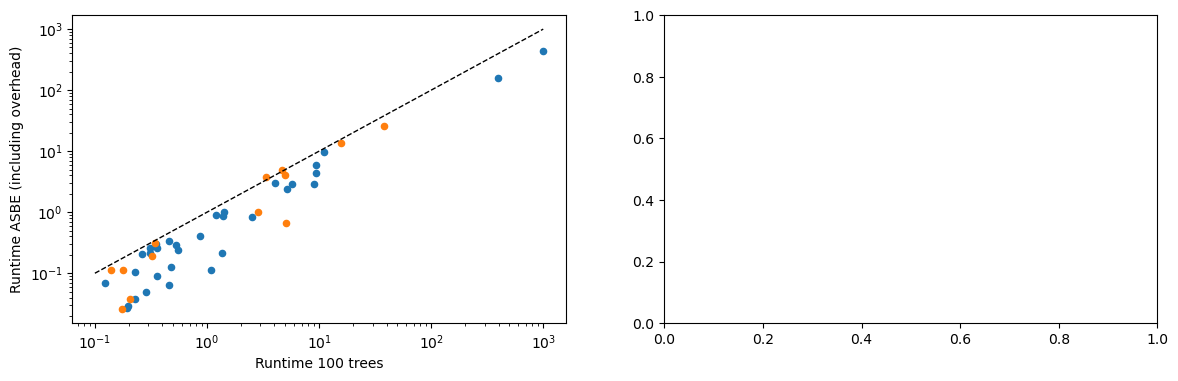

0.3


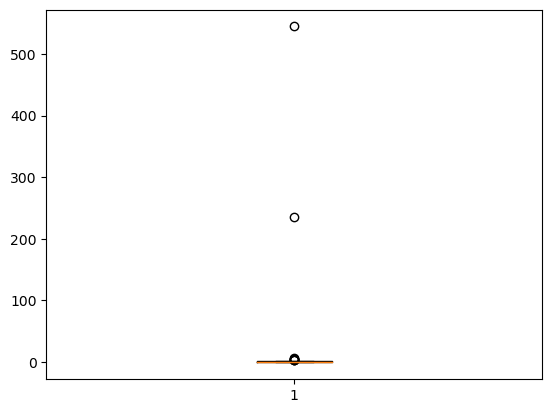

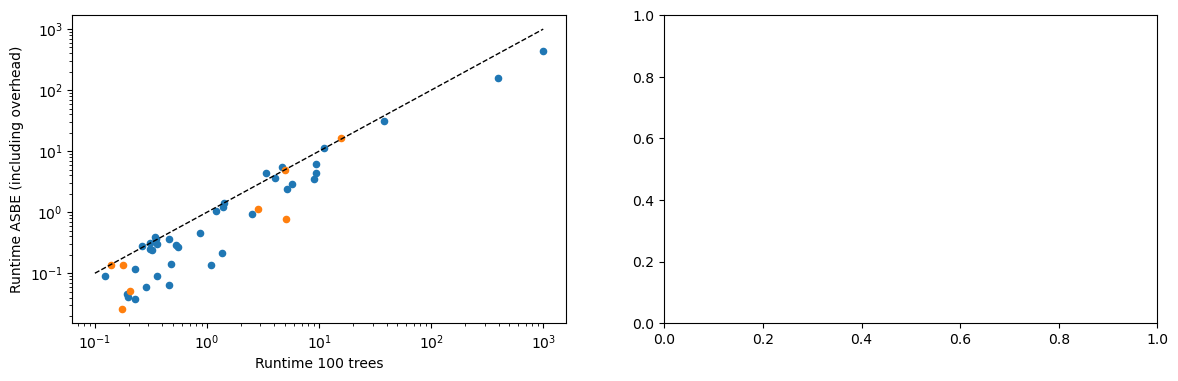

0.4


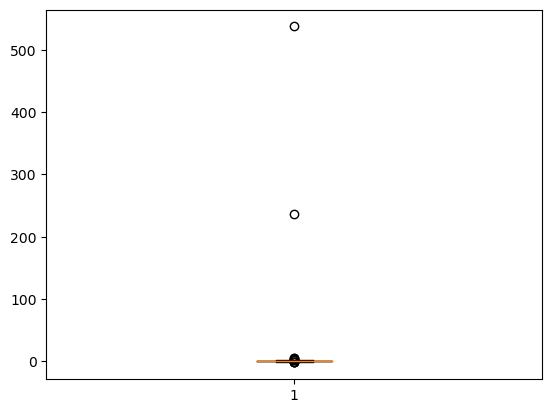

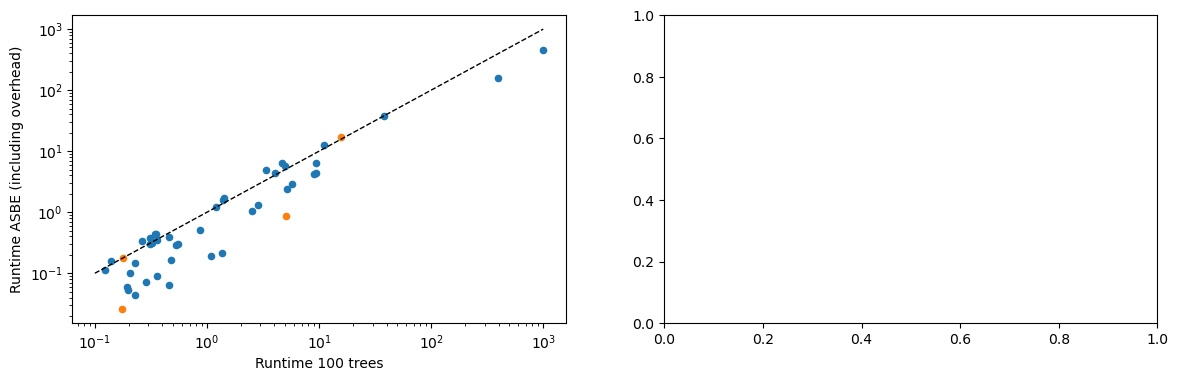

0.5


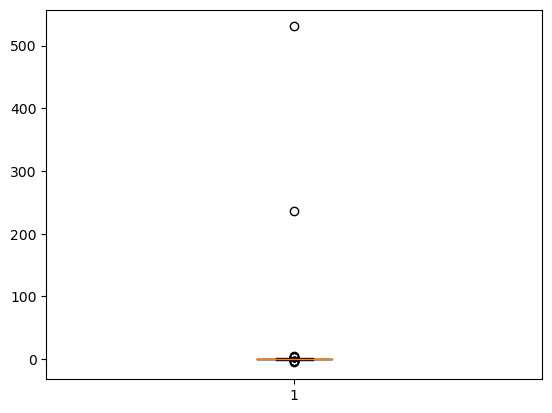

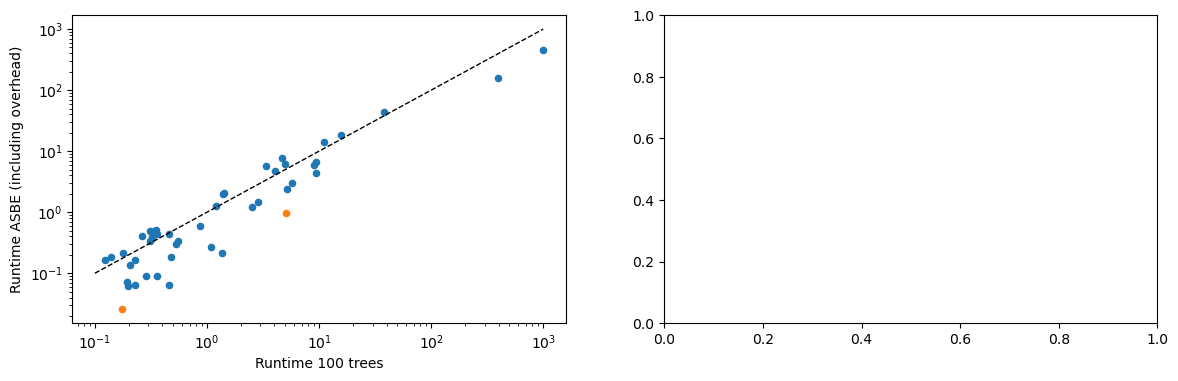

0.6


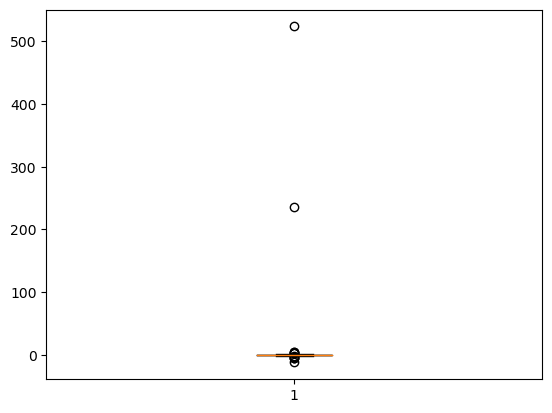

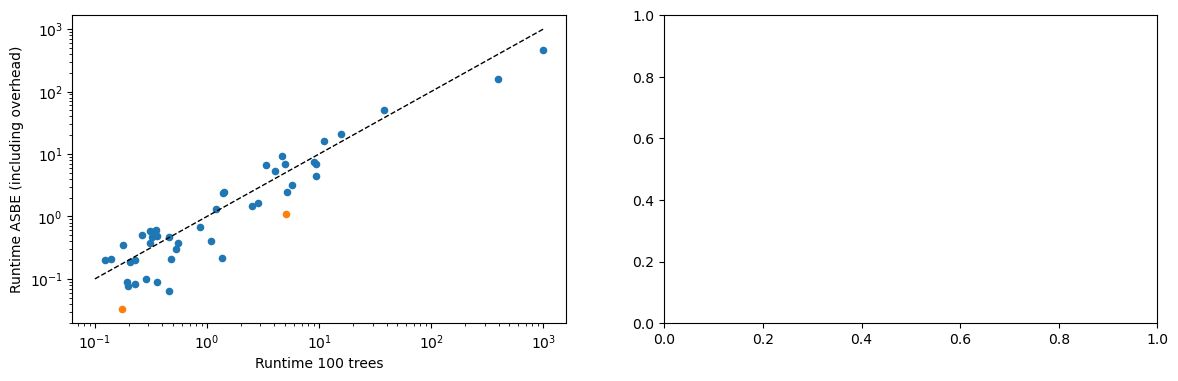

0.7


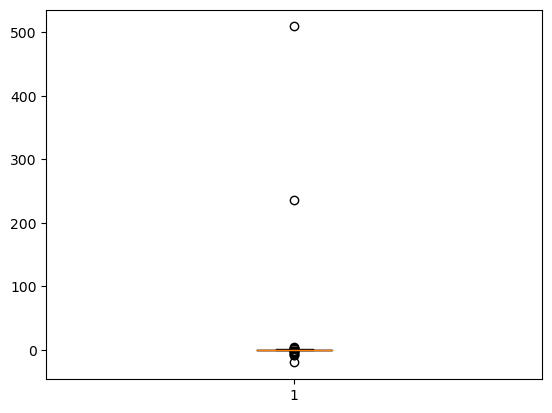

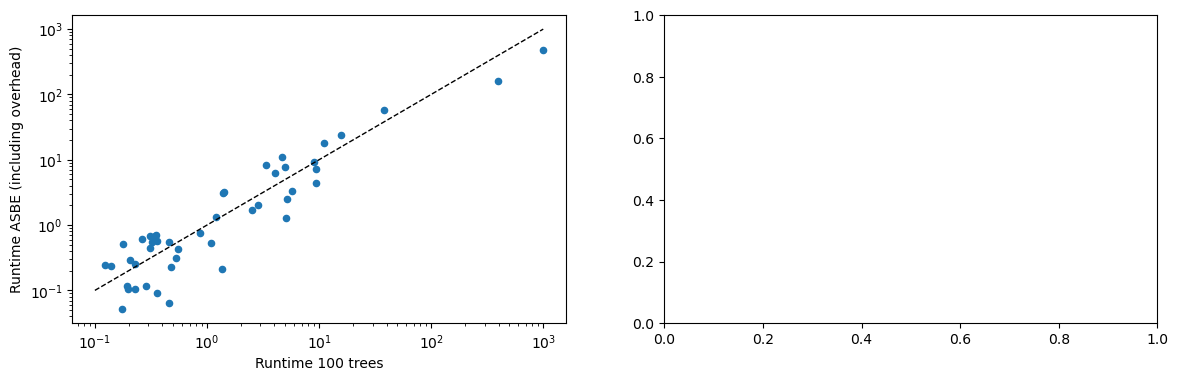

0.8


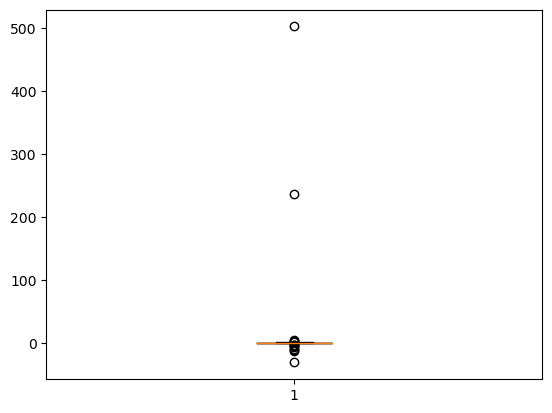

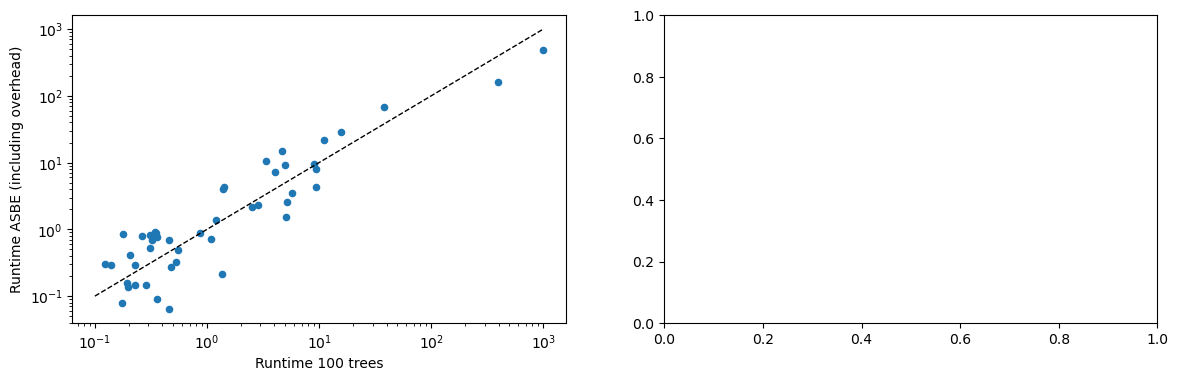

0.9


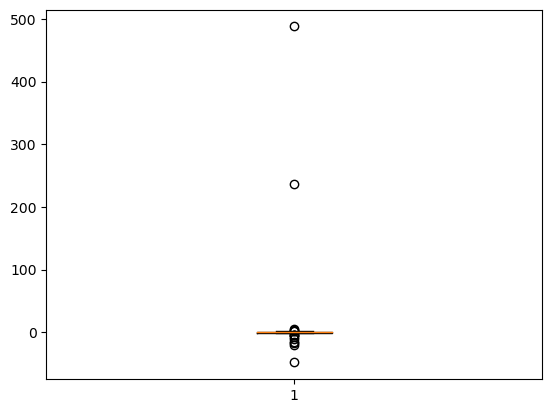

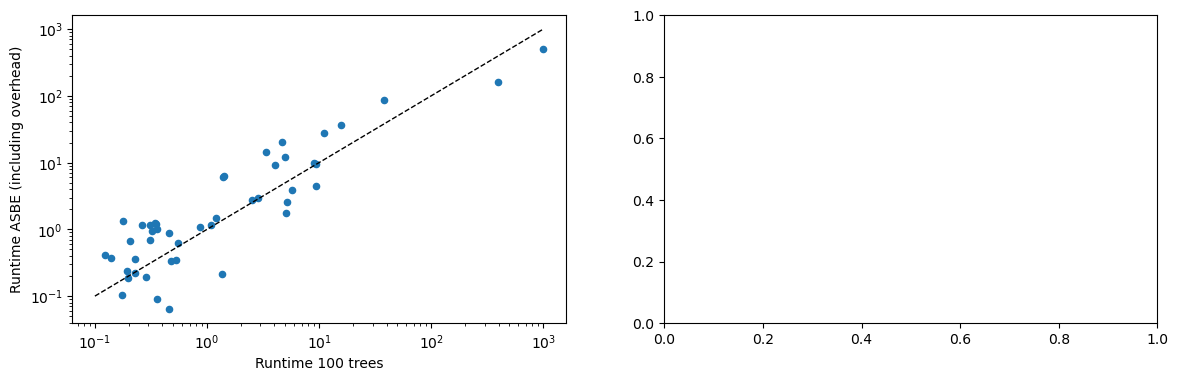

0.95


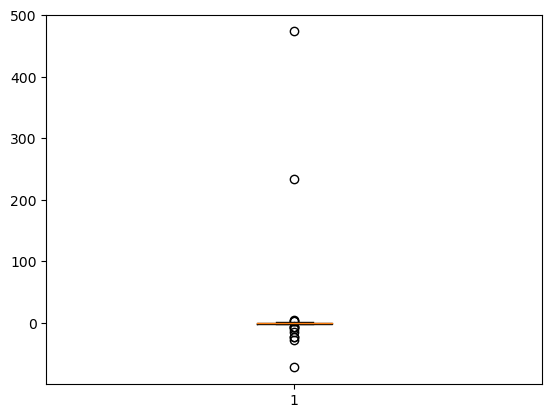

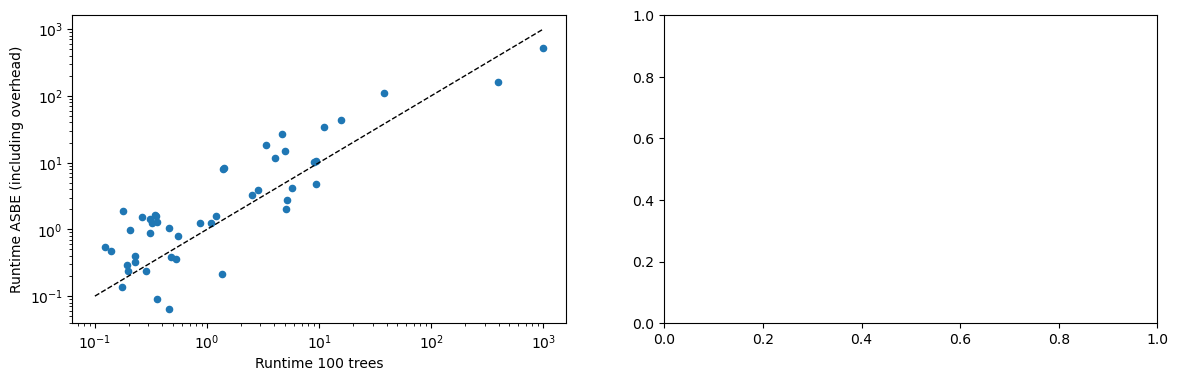

0.99


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

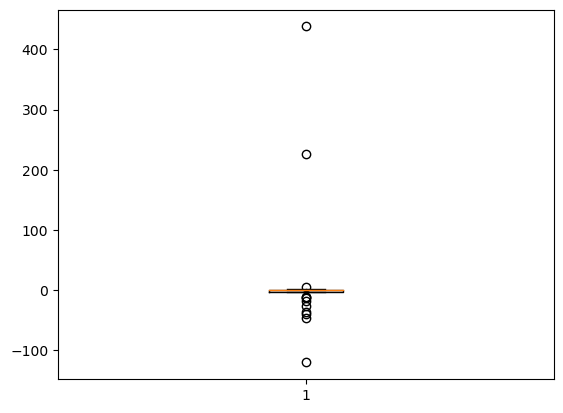

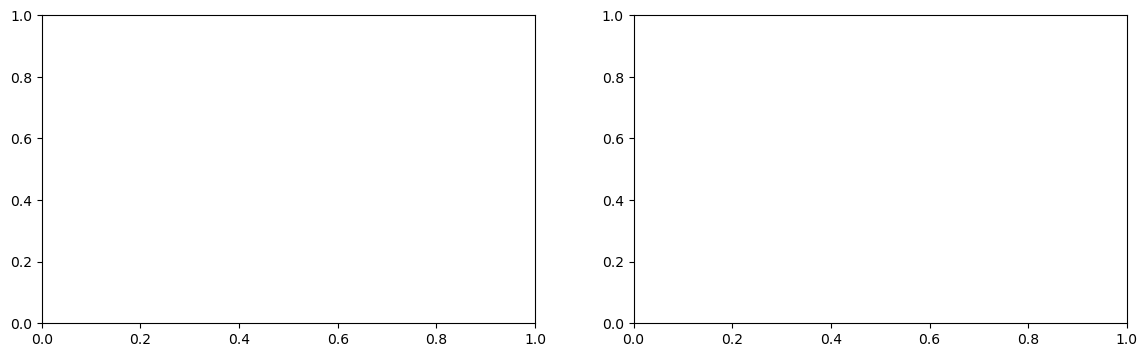

In [38]:
for idx, alpha in enumerate(alphas):
    print(alpha)
    plt.boxplot(runtimes_baseline - runtimes_asrf[:,idx])

    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    ax = axs[0]
    mask = df_results[f"ok_{alpha}"]
    ax.scatter(runtimes_baseline[mask], runtimes_asrf[mask,idx], s=20)
    ax.scatter(runtimes_baseline[~mask], runtimes_asrf[~mask,idx], s=20)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.plot([0.1, 10**3], [0.1, 10**3], linestyle="--", color="black", linewidth=1)
    ax.set_xlabel("Runtime 100 trees")
    ax.set_ylabel("Runtime ASBE (including overhead)")
    plt.show()

# CREATE 3D plot with (#validation instances, #trees, gap)
We would expect the gap to drop very quickly for larger datasets, because the variance for both scores should be small (those for probabilities can still be large).

In [ ]:
np.nanmean(prob_history[:10], axis=0)

In [ ]:
prob_history = prob_history_val
Y = Y_test
brier_score_per_forest_size = [np.nanmean(((Y - np.nanmean(prob_history[:t], axis=0))**2).sum(axis=1)) for t in tqdm(range(1, 500))]
brier_score_per_forest_size

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(range(len(brier_score_per_forest_size)), brier_score_per_forest_size)
ax.set_ylim([0, 0.05])
plt.show()